In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import seaborn as sns
#import GMM
from statsmodels.sandbox.regression.gmm import GMM, NonlinearIVGMM, LinearIVGMM
import statsmodels.api as sm
#set seaborn graphics
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
pathdata = os.getcwd()+'/Data'
os.chdir(pathdata)
df_gdp = pd.read_pickle('PRate.pkl')
df_gdp.index = df_gdp['SurveyDate']
df_gdp = df_gdp.drop('SurveyDate', axis=1)

# load shocks

In [3]:
oisfactors = pd.read_csv('dataset_con.csv')
oisfactors.index = pd.to_datetime(oisfactors['Date'])
oisfactors

,1M,3M,6M,1Y,2Y,5Y,10Y,Date,ConfFactor1,ConfFactor2,ConfFactor3
Date,,,,,,,,,,,
2002-01-03,0.0125,0.0125,0.0070,0.00500,-0.0050,-0.0105,-0.0140,2002-01-03,1.984610,-2.013147,-0.765204
2002-02-07,0.0050,0.0080,0.0050,0.01250,0.0145,0.0240,0.0210,2002-02-07,0.803178,0.588936,1.714052
2002-03-07,0.0050,0.0000,0.0020,-0.00500,-0.0050,0.0025,0.0025,2002-03-07,0.502155,-0.819328,0.754432
2002-04-04,-0.0075,-0.0125,-0.0100,-0.02250,-0.0300,-0.0240,-0.0230,2002-04-04,-0.944470,-1.100228,-1.087792
2002-05-02,0.0050,0.0200,0.0425,0.07000,0.0725,0.0615,0.0530,2002-05-02,2.389232,4.821021,1.451719
...,...,...,...,...,...,...,...,...,...,...,...
2018-03-08,-0.0018,0.0000,0.0040,-0.00175,-0.0077,-0.0258,-0.0290,2018-03-08,0.332580,-0.231835,-2.799684
2018-04-26,0.0000,0.0000,0.0000,-0.00100,-0.0030,0.0000,0.0030,2018-04-26,0.271545,-0.314816,0.421258
2018-06-14,0.0000,0.0000,0.0000,0.00000,-0.0040,-0.0080,-0.0050,2018-06-14,0.304379,-0.304242,-0.458284


In [4]:
#End of period DEFINITION - always take the last shock
mpdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Monetary Event Window')
mpdf.index = mpdf['date']
prdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Release Window')
prdf.index = prdf['date']
pcdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Conference Window')
pcdf.index = pcdf['date']
pcdf = pd.concat([pcdf, oisfactors], axis = 1)
##get OLS estimate of the OIS 3Y
pcdf1 = pcdf.loc[(pcdf.index>'2001-12-01')&(pcdf.index<'2015-01-01')]
pcdf1 = pcdf1.dropna(subset=['OIS_1M', 'OIS_3M', 'OIS_6M', 'OIS_1Y', 'OIS_2Y', 'OIS_3Y'])
X = sm.add_constant(pcdf1[['OIS_1M', 'OIS_3M', 'OIS_6M', 'OIS_1Y']])
model = sm.OLS(pcdf1['OIS_3Y'], X)
results = model.fit()
#get the residuals and the fitted values
oisnew = pd.DataFrame(results.resid)
oisnew.columns = ['oisnew']
oisnew.index = pcdf1.index
oisnewfitted = pd.DataFrame(results.fittedvalues)
oisnewfitted.columns = ['oisnew_fitted']
oisnewfitted.index = pcdf1.index
pcdf = pd.concat([pcdf, oisnew], axis = 1)
pcdf = pd.concat([pcdf, oisnewfitted], axis = 1)

dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdf = mpdf.loc[(mpdf.index<date1)].tail(1)
#tale always the last announcement
for i in range(0, len(dates_list)-1):
    newdfwork = mpdf.loc[(mpdf.index>dates_list[i])&(mpdf.index<dates_list[i+1])].tail(1)
    #print(newdfwork)
    newdf = newdf.append(newdfwork)
newdf.index = dates_list
#repeat same for press conference
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfpr = prdf.loc[(prdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfpr = newdfpr.append(prdf.loc[(prdf.index>dates_list[i])&(prdf.index<dates_list[i+1])].tail(1))
newdfpr.index = dates_list

#repeat same for press release
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfpc = pcdf.loc[(pcdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfpc = newdfpc.append(pcdf.loc[(pcdf.index>dates_list[i])&(pcdf.index<dates_list[i+1])].tail(1))
newdfpc.index = dates_list

#SUM DEFINITION
#mpdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Monetary Event Window')
#mpdf.index = mpdf['date']
#prdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Release Window')
#prdf.index = prdf['date']
#pcdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Conference Window')
#pcdf.index = pcdf['date']
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfsum = mpdf.loc[(mpdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfworksum = mpdf.loc[(mpdf.index>dates_list[i])&(mpdf.index<dates_list[i+1])].sum()
    newdfsum = newdfsum.append(newdfwork, ignore_index = True)
newdfsum.index = dates_list
#repeat same for press conference
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfprsum = prdf.loc[(prdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfprsum = newdfprsum.append(prdf.loc[(prdf.index>dates_list[i])&(prdf.index<dates_list[i+1])].sum(), ignore_index = True)
newdfprsum.index = dates_list

#repeat same for press release
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfpcsum = pcdf.loc[(pcdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfpcsum = newdfpcsum.append(pcdf.loc[(pcdf.index>dates_list[i])&(pcdf.index<dates_list[i+1])].sum(),ignore_index = True)
newdfpcsum.index = dates_list

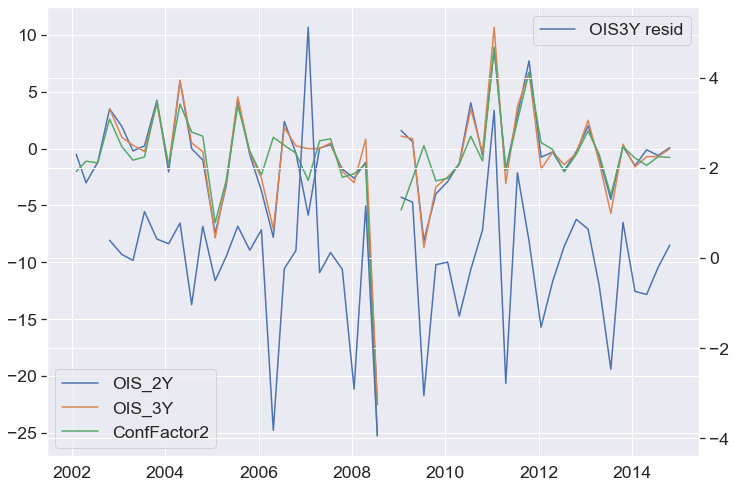

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.6);
fig, ax1 = plt.subplots()
ax1.plot(newdfpc.loc[(newdfpc.index>'2001-12-01')&(newdfpc.index<'2015-01-01')][['OIS_2Y', 'OIS_3Y', 'ConfFactor2']])
ax1.legend(['OIS_2Y', 'OIS_3Y', 'ConfFactor2'])
ax2 = ax1.twinx()
ax2.plot(newdfpc.loc[(newdfpc.index>'2001-12-01')&(newdfpc.index<'2015-01-01')]['oisnew']);
ax2.legend(['OIS3Y resid']);

# transform data into means

In [7]:
df_gdp = df_gdp.drop(['IRQ4'], axis = 1)
df_gdp

,Source,CurrentIR,IRQ1,IRQ2,IRQ3
SurveyDate,,,,,
1999-02-12,1,NaN,NaN,NaN,NaN
1999-02-12,2,NaN,NaN,NaN,NaN
1999-02-12,3,NaN,NaN,NaN,NaN
1999-02-12,4,NaN,NaN,NaN,NaN
1999-02-12,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-01-13,124,NaN,NaN,NaN,NaN
2020-01-13,125,NaN,NaN,NaN,NaN
2020-01-13,126,NaN,NaN,NaN,NaN


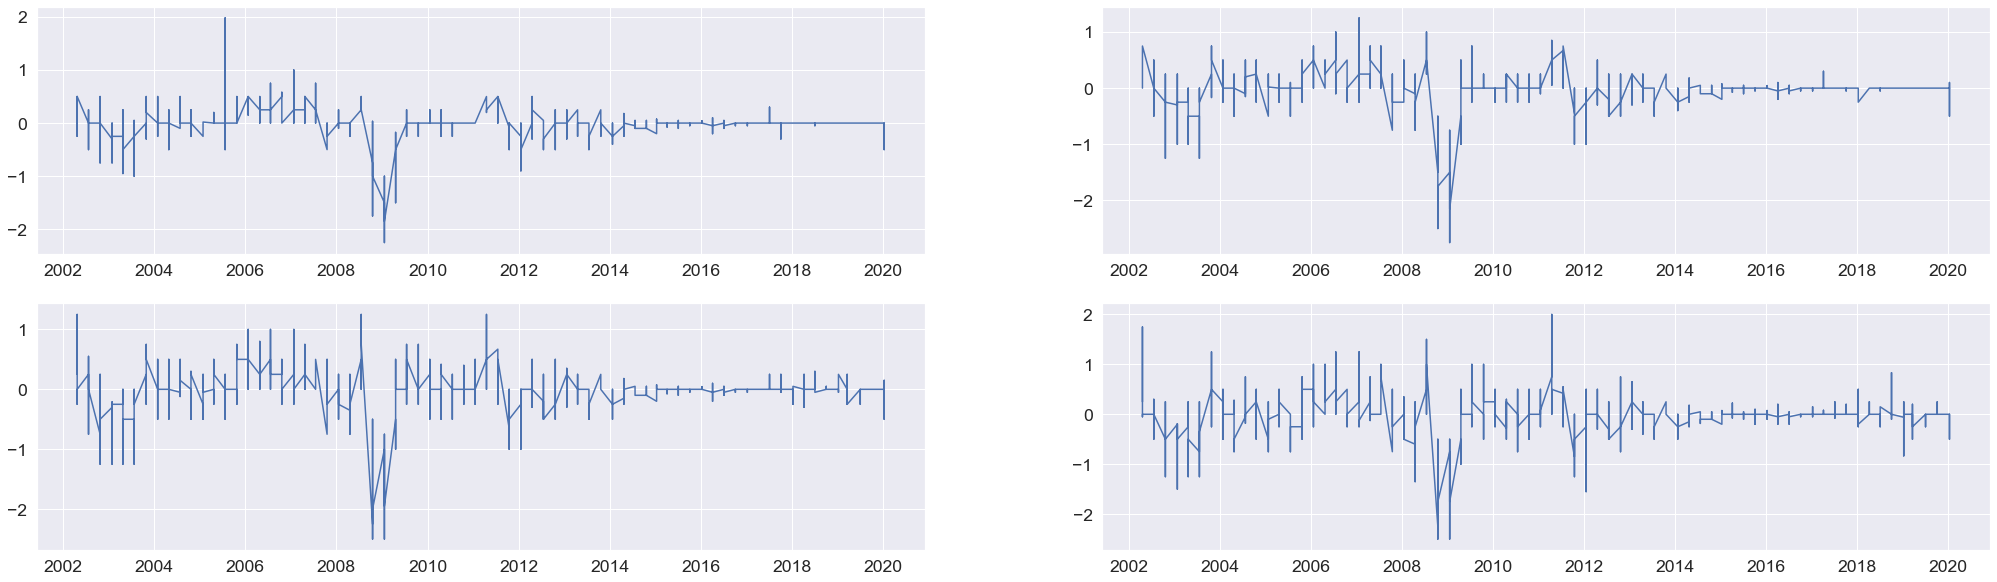

In [9]:
df_gdp['CurrentIR'] = df_gdp['CurrentIR'].astype(float)
df_gdp['IRQ1'] = df_gdp['IRQ1'].astype(float)
df_gdp['IRQ2'] = df_gdp['IRQ2'].astype(float)
df_gdp['IRQ3'] = df_gdp['IRQ3'].astype(float)
#df_gdp['IRQ4'] = df_gdp['IRQ4'].astype(float)
dfgdp1 = df_gdp.sort_values(by=['Source', 'SurveyDate'],ascending = [True, True])
dfgdp1['diffCurrentIR'] = dfgdp1['CurrentIR'].diff()
dfgdp1['diffIRQ1'] = dfgdp1['IRQ1'].diff()
dfgdp1['diffIRQ2'] = dfgdp1['IRQ2'].diff()
dfgdp1['diffIRQ3'] = dfgdp1['IRQ3'].diff()
#dfgdp1['diffIRQ4'] = dfgdp1['IRQ4'].diff()
dfgdp1 = dfgdp1.sort_index()

fig, axs = plt.subplots(2, 2, figsize=(35, 10));
axs[0,0].plot(dfgdp1['diffCurrentIR'].dropna().astype(float))
axs[0,1].plot(dfgdp1['diffIRQ1'].dropna().astype(float))
axs[1,0].plot(dfgdp1['diffIRQ2'].dropna().astype(float))
axs[1,1].plot(dfgdp1['diffIRQ3'].dropna().astype(float))

In [56]:
from scipy.stats import zscore
#df_gdpnew = df_gdp.drop(['IRQ4'], axis = 1)
df_gdpnew = df_gdp.dropna()
z_scores = zscore(df_gdpnew)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = df_gdpnew[filtered_entries]

In [59]:
len(df_gdpnew)

3669

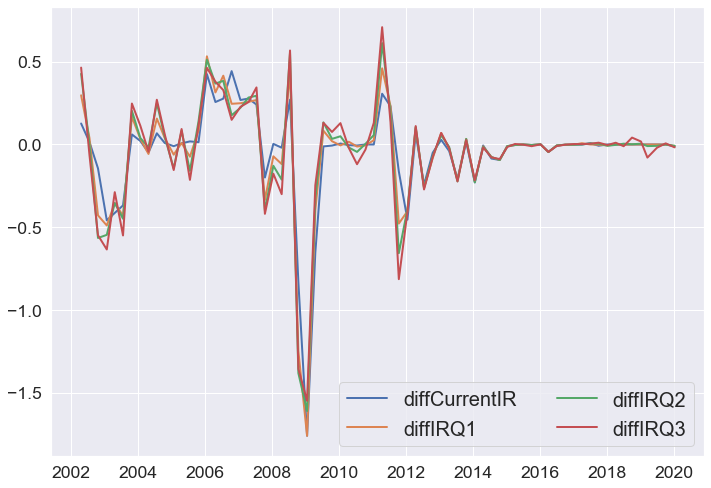

In [13]:
df1gdpmeans = dfgdp1.groupby('SurveyDate')[['diffCurrentIR',
       'diffIRQ1', 'diffIRQ2', 'diffIRQ3']].mean()

sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.6);
plt.plot(df1gdpmeans, linewidth=2.0);
plt.legend(list(df1gdpmeans), ncol=2, loc='lower right', fontsize=20);

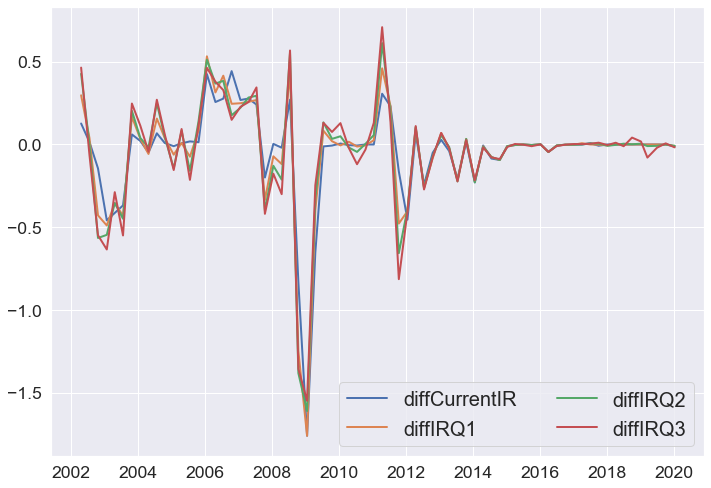

In [28]:
df1gdpmeansnew = dfgdp1.groupby('SurveyDate')[['CurrentIR',
       'IRQ1', 'IRQ2', 'IRQ3']].mean()
df1gdpmeansnew = df1gdpmeansnew.diff()
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.6);
plt.plot(df1gdpmeans, linewidth=2.0);
plt.legend(list(df1gdpmeans), ncol=2, loc='lower right', fontsize=20);

In [43]:
dataols.columns

Index(['diffCurrentIR', 'diffIRQ1', 'diffIRQ2', 'diffIRQ3', 'date', 'OIS_SW',
       'OIS_1M', 'OIS_3M', 'OIS_6M', 'OIS_1Y', 'OIS_2Y', 'OIS_3Y', 'OIS_4Y',
       'OIS_5Y', 'OIS_6Y', 'OIS_7Y', 'OIS_8Y', 'OIS_9Y', 'OIS_10Y', 'OIS_15Y',
       'OIS_20Y', 'DE3M', 'DE6M', 'DE1Y', 'DE2Y', 'DE3Y', 'DE4Y', 'DE5Y',
       'DE6Y', 'DE7Y', 'DE8Y', 'DE9Y', 'DE10Y', 'DE15Y', 'DE20Y', 'DE30Y',
       'IT2Y', 'FR2Y', 'ES2Y', 'IT5Y', 'ES5Y', 'FR5Y', 'ES10Y', 'FR10Y',
       'IT10Y', 'STOXX50', 'SX7E', 'EURUSD', 'EURGBP', 'EURJPY'],
      dtype='object')

In [66]:
##get OLS estimate of the OIS 3Y
#order data
dataols = pd.concat([df1gdpmeans, newdfpr], axis=1)
var = 'OIS_3M'
yvar = 'diffCurrentIR'
dataols = dataols.dropna(subset = [var, yvar]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2001-12-01')&(dataols.index<'2015-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
X = sm.add_constant(dataols[[var]])
model = sm.OLS(dataols[yvar], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          diffCurrentIR   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     7.540
Date:                Wed, 23 Sep 2020   Prob (F-statistic):            0.00842
Time:                        00:34:52   Log-Likelihood:                -14.095
No. Observations:                  51   AIC:                             32.19
Df Residuals:                      49   BIC:                             36.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0546      0.046     -1.198      0.2

In [ ]:
corr_matrix = np.corrcoef(hie_data.data.T)
smg.plot_corr(corr_matrix, xnames=hie_data.names)
plt.show()

In [69]:
dataols[var].corr(dataols[yvar])

0.3651792071068138